In [127]:
# Load necessary libraries
import pandas as pd
pd.set_option("display.max_rows", 1001)
pd.set_option("display.max_columns", 1001)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sn


In [2]:
# Load passing play data from NFL 2021 Big Bowl Dataset into datframe
passes = pd.read_csv("nfl-big-data-bowl-2021/plays.csv")
passes = passes.rename(columns = {"passCatcher":"playerName", "possessionTeam":"Tm"})

In [4]:
# Load route data recovered seperate file from NFL 2021 Big Bowl Dataset into datframe
rt = pd.read_csv("all_routes_v2.csv")

In [5]:
# Merge two previous datasets based the game, play and the receiver who was targeted in order to have the route info
#  and EPA value for each passing play in one dataframe
# Result is main dataframe from which following dataframes are created 
fData = pd.merge(rt,passes, on =("gameId","playId","playerName","Tm"), how='inner')

In [7]:
# Load in 2018 team data to recover each team's season winning percentage
pfr2 = pd.read_csv("NFL Team 2018 PFR Stats.csv")

In [124]:
# Create new dataframe based on main dataframe where each column corresponds to sample of all EPA values recorded
#  for the 11 routes being analyzed 
epaPtsByRoute = fData[['route','epa']]
epaPtsByRoute = epaPtsByRoute.pivot_table(values='epa', index=epaPtsByRoute.index, columns='route',aggfunc='first')
epaPtsByRoute = epaPtsByRoute.drop(['WHEEL','undefined'],axis=1)
epaPtsByRoute

route,ANGLE,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT
0,NaN,NaN,NaN,NaN,NaN,0.261827,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,-0.372360,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.702779,NaN
3,NaN,3.04753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.842272,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15155,0.242491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15156,NaN,NaN,NaN,-0.719429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.632439,NaN,NaN
15158,NaN,NaN,NaN,-0.112840,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# Create dataframe to countnumber of EPA values to each route type
routeCount = fData.groupby(['route']).size().reset_index().rename(columns={0:'count'})
routeCount.sort_values(by=["count"])

,route,count
12,undefined,15
11,WHEEL,108
1,CORNER,421
0,ANGLE,623
8,POST,793
6,IN,980
10,SLANT,1026
9,SCREEN,1419
4,GO,1510
2,CROSS,1851


In [96]:
# Function to store samples of EPA values for given route into seperate arrays and removing all "NaN" values found
def sampleCreation(routeName):
    routeArr = np.array(epaPtsByRoute[routeName])
    routeArr = routeArr[~np.isnan(routeArr)]
    return routeArr

In [126]:
# Create individual arrays for 11 routes using previously defined function and store all of them in seperate array
angle = sampleCreation("ANGLE")
corner = sampleCreation("CORNER")
cross = sampleCreation("CROSS")
flat = sampleCreation("FLAT")
go = sampleCreation("GO")
hitch = sampleCreation("HITCH")
in1 = sampleCreation("IN")
out = sampleCreation("OUT")
post = sampleCreation("POST")
screen = sampleCreation("SCREEN")
slant = sampleCreation("SLANT")
routes = [angle,corner,cross,flat,go,hitch,in1,out,post,screen,slant]

In [130]:
# For loop to conduct Shapiro-Wilks on each of the of the 11 samples 
import math
from scipy.stats import shapiro
for i in routes:
    np.random.seed(1)
    print(shapiro(i))

ShapiroResult(statistic=0.854644775390625, pvalue=1.635856441535743e-23)
ShapiroResult(statistic=0.9578487873077393, pvalue=1.2919316727533214e-09)
ShapiroResult(statistic=0.939529299736023, pvalue=7.896401364765109e-27)
ShapiroResult(statistic=0.8948325514793396, pvalue=4.2342893548786776e-35)
ShapiroResult(statistic=0.9345787763595581, pvalue=3.210757808001046e-25)
ShapiroResult(statistic=0.8873869180679321, pvalue=7.997851570079006e-38)
ShapiroResult(statistic=0.970036506652832, pvalue=2.4734061370226823e-13)
ShapiroResult(statistic=0.9384766817092896, pvalue=8.308696502798508e-29)
ShapiroResult(statistic=0.9699510931968689, pvalue=1.0569427277840049e-11)
ShapiroResult(statistic=0.8528525233268738, pvalue=2.0484554858287854e-34)
ShapiroResult(statistic=0.9263295531272888, pvalue=5.140708897883012e-22)


In [132]:
# Conduct one-way ANOVA on the 11 samples 
from scipy.stats import f_oneway
f_oneway(angle,corner,cross,flat,go,hitch,in1,out,post,screen,slant)

F_onewayResult(statistic=12.58300982542046, pvalue=4.1596066261888263e-22)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fec9cd7b2b0>)

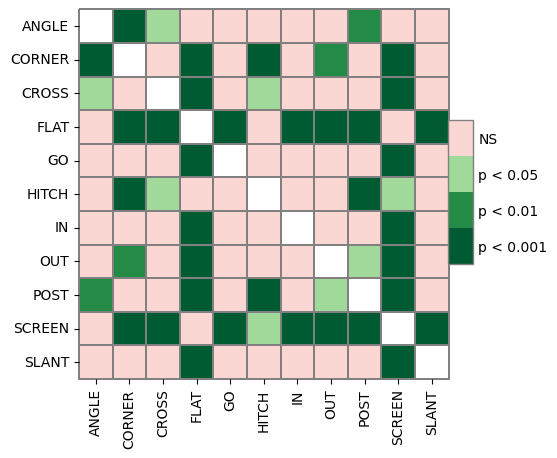

In [167]:
# Conduct Bonferroni Mutiple Comparison Post Hoc Test on the 11 samples and visualize results in heatmap
import scikit_posthocs as sp
x = [angle,corner,cross,flat,go,hitch,in1,out,post,screen,slant]
label = ['ANGLE','CORNER','CROSS','FLAT','GO','HITCH','IN','OUT','POST','SCREEN','SLANT']
pc = sp.posthoc_ttest(x, p_adjust = 'bonferroni')
heatmap_args = {'linewidths': 0.25, 'xticklabels': xlabel, 'yticklabels': xlabel, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

,route,count
12,undefined,15
11,WHEEL,108
1,CORNER,421
0,ANGLE,623
8,POST,793
6,IN,980
10,SLANT,1026
9,SCREEN,1419
4,GO,1510
2,CROSS,1851


In [137]:
# Sum up EPA values by route for each of the quarterback's found in the original datset 
qb = fData.pivot_table('epa', ['QB', 'Tm','route'], aggfunc='sum').reset_index()
qb.sort_values(by=['QB',"Tm"])

,QB,Tm,route,epa
0,A.Brown,PIT,WHEEL,-0.280316
1,A.Corbett,CLE,CROSS,2.632705
2,A.Dalton,CIN,ANGLE,0.098121
3,A.Dalton,CIN,CORNER,-0.737890
4,A.Dalton,CIN,CROSS,22.793054
5,A.Dalton,CIN,FLAT,-12.243661
6,A.Dalton,CIN,GO,14.885930
7,A.Dalton,CIN,HITCH,-14.216999
8,A.Dalton,CIN,IN,4.906562
9,A.Dalton,CIN,OUT,6.585720


In [143]:
# Count total number of passing plays in originial dataset each quarterback was involved in
qbAttCount = fData.groupby(['QB', 'Tm']).size().reset_index().rename(columns={0:'count'})
qbAttCount

,QB,Tm,count
0,A.Brown,PIT,1
1,A.Corbett,CLE,1
2,A.Dalton,CIN,354
3,A.Luck,IND,598
4,A.McCarron,OAK,1
5,A.Rodgers,GB,530
6,A.Smith,WAS,315
7,A.Wilson,MIA,1
8,B.Bortles,JAX,397
9,B.Clausell,ARI,1


In [163]:
# Create dataframe with every quarterback's total EPA for each route, the route it is referencing, the total number
#  of passing plays involved in and their team's wiining percentage
# Drop all QBs that were involved in under 200 passing plays to only account for starting QBs
# Drop all unneccassary columns
qbEPA = pd.merge(qb,qbAttCount,on=("QB","Tm"),how="inner")
qbEPA = qbEPA.rename(columns = {"epa":"epaRoute", "count":"countTotal"})
qbEPA = qbEPA.loc[qbEPA['countTotal']>=200]
qbEPA = pd.merge(qbEPA,pfr2, on ="Tm", how='inner')
qbEPA = qbEPA.drop(['TeamName','W',"L",'T','PA','MoV','SoS','SRS','OSRS','DSRS','PF','PD'],axis=1)
qbEPA

,QB,Tm,route,epaRoute,countTotal,W-L%
0,A.Dalton,CIN,ANGLE,0.098121,354,0.375
1,A.Dalton,CIN,CORNER,-0.737890,354,0.375
2,A.Dalton,CIN,CROSS,22.793054,354,0.375
3,A.Dalton,CIN,FLAT,-12.243661,354,0.375
4,A.Dalton,CIN,GO,14.885930,354,0.375
5,A.Dalton,CIN,HITCH,-14.216999,354,0.375
6,A.Dalton,CIN,IN,4.906562,354,0.375
7,A.Dalton,CIN,OUT,6.585720,354,0.375
8,A.Dalton,CIN,POST,-2.428104,354,0.375
9,A.Dalton,CIN,SCREEN,5.822627,354,0.375


In [162]:
# Reoriente previous dataframe to have Total EPA by route as indiviual columns and recover columns 
#  lost from reoirentation
qbEpaByRoute = qbEPA.pivot_table(values='epaRoute', index='QB', columns='route',aggfunc='first')
qbEpaByRoute = qbEpaByRoute.drop(['WHEEL','undefined'],axis=1)
qbEpaByRoute = pd.merge(qbEpaByRoute,qbEPA, on ="QB", how='inner')
qbEpaByRoute = qbEpaByRoute.drop_duplicates(subset=['QB','Tm'])
qbEpaByRoute = qbEpaByRoute.drop(['route','epaRoute','countTotal'],axis=1)
qbEpaByRoute

,QB,ANGLE,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,Tm,W-L%
0,A.Dalton,0.098121,-0.737890,22.793054,-12.243661,14.885930,-14.216999,4.906562,6.585720,-2.428104,5.822627,7.104360,CIN,0.375
12,A.Luck,10.436373,11.569221,22.455469,-13.164995,29.879974,13.702210,-4.280514,18.182871,26.050484,-14.817784,8.168264,IND,0.625
24,A.Rodgers,-2.477850,-3.352703,23.852725,-3.719970,44.067527,5.391682,13.895386,15.585949,9.128386,-2.871445,11.075977,GB,0.406
36,A.Smith,-1.172577,-10.521691,14.248377,2.999553,-0.144563,-21.958611,6.878488,-3.888462,14.037920,-11.268176,18.979328,WAS,0.438
48,B.Bortles,-1.038128,14.010228,-5.535015,-6.926589,-8.462270,-14.549814,-0.475725,7.950097,0.549519,-15.264245,-6.090610,JAX,0.313
61,B.Mayfield,4.384676,11.922767,-16.725622,7.057180,26.252525,-15.853428,4.467067,-0.562451,6.795585,-1.335953,8.269702,CLE,0.469
73,B.Roethlisberger,11.479286,4.716663,4.121773,5.295813,43.175234,9.878568,-0.510574,34.378632,-1.134917,7.638592,18.059088,PIT,0.594
84,C.Keenum,-5.345570,3.212042,-6.149457,-14.619290,7.485617,3.656992,6.838915,5.662791,3.637183,-0.780891,-7.100425,DEN,0.375
97,C.Newton,10.407132,4.039281,-3.521645,14.341539,-13.011723,13.655823,1.859354,8.735303,0.070714,-4.929824,5.234250,CAR,0.438
109,C.Wentz,1.829178,16.847551,18.918728,-10.770741,0.341301,20.973881,9.501016,14.670219,-5.906768,2.596280,11.201903,PHI,0.563


In [164]:
# Function to run mutiple linear regression with dependent variable being Team Win% and independent variables being
#  QB's Total EPA on any combination of routes (xData)
def multipleLR (xData):
    x = xData
    x = sm.add_constant(x)
    model = sm.OLS(qbEpaByRoute['W-L%'], x).fit()
    predictions = model.predict(x) 
    print_model = model.summary()
    print(print_model)

In [109]:
# Create 1st mutiple linear regression model with all 11 routes
multipleLR(qbEpaByRoute[['ANGLE','CORNER','CROSS','FLAT','GO','HITCH','IN','OUT','POST','SCREEN','SLANT']])

                            OLS Regression Results                            
Dep. Variable:                   W-L%   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     2.795
Date:                Tue, 06 Dec 2022   Prob (F-statistic):             0.0206
Time:                        17:21:47   Log-Likelihood:                 25.010
No. Observations:                  33   AIC:                            -26.02
Df Residuals:                      21   BIC:                            -8.063
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3741      0.051      7.341      0.0

/var/folders/_0/qnhs7l4d4992bmqmgwcyqj240000gn/T/ipykernel_13750/4131773270.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(qbEpaByRoute.corr(),annot=True)


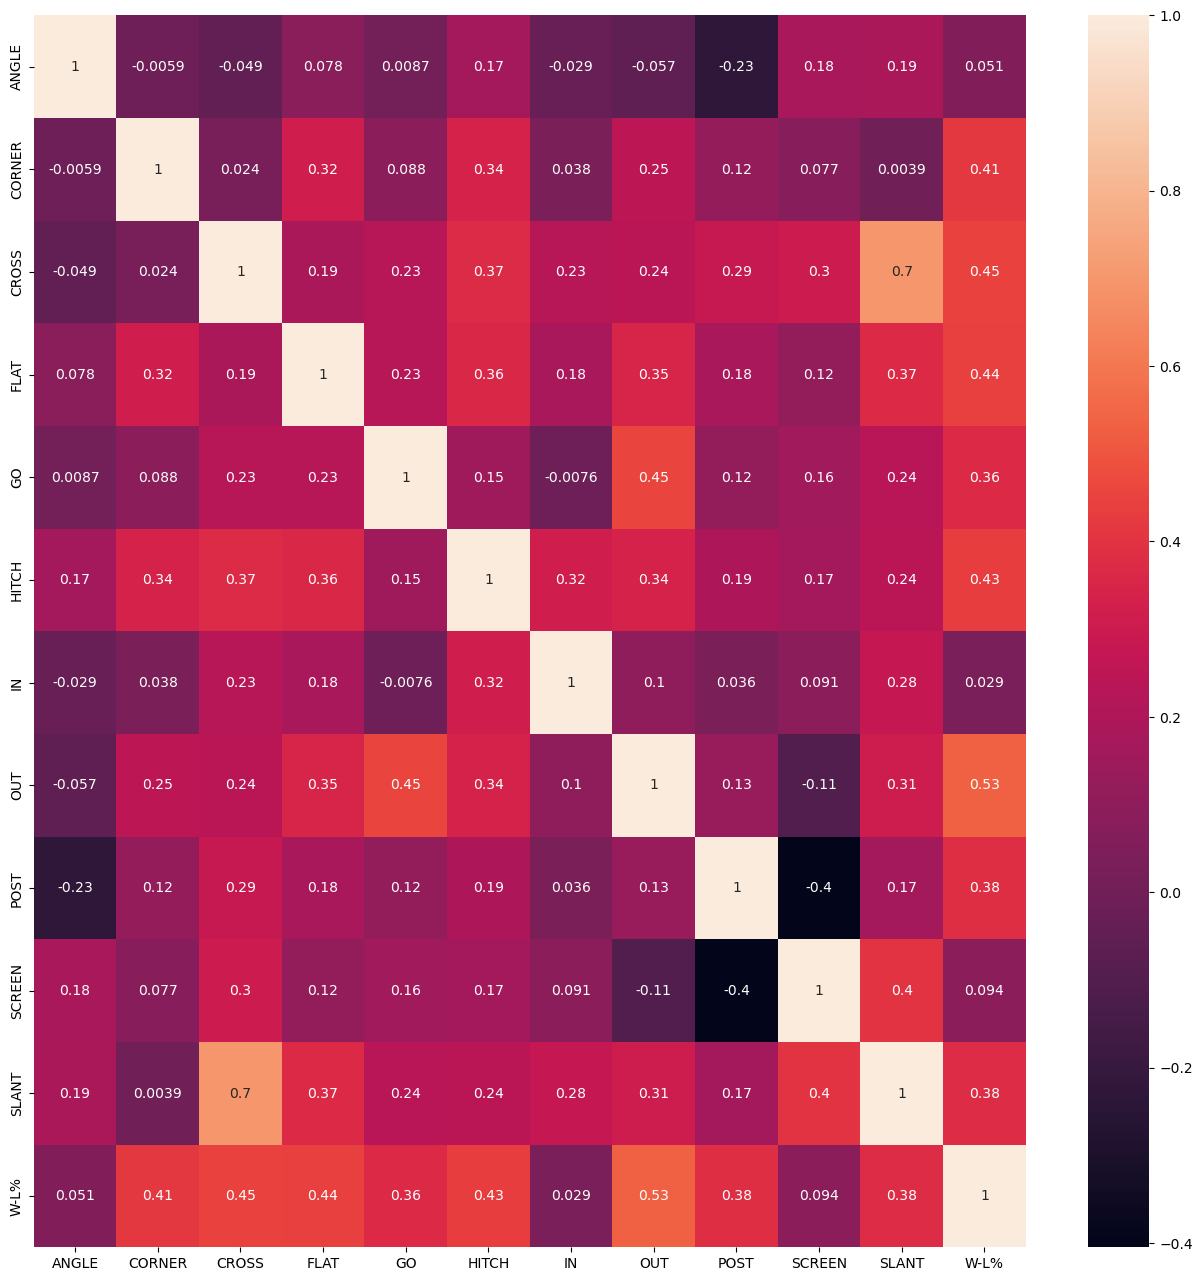

In [110]:
# Construct correlation matrix to determine which one 11 routes have highest correlation to Win% on total EPA level
plt.figure(figsize=(16,16))
sn.heatmap(qbEpaByRoute.corr(),annot=True)
plt.show()

In [112]:
# Create 2nd mutiple linear regression model with 5 routes (Corner, Cross, Flat, Hitch, Out) determined
#  results of previous matrix
multipleLR(qbEpaByRoute[['CORNER','CROSS','FLAT','HITCH','OUT']])

                            OLS Regression Results                            
Dep. Variable:                   W-L%   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     5.691
Date:                Tue, 06 Dec 2022   Prob (F-statistic):            0.00104
Time:                        17:23:44   Log-Likelihood:                 22.005
No. Observations:                  33   AIC:                            -32.01
Df Residuals:                      27   BIC:                            -23.03
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3828      0.036     10.552      0.0

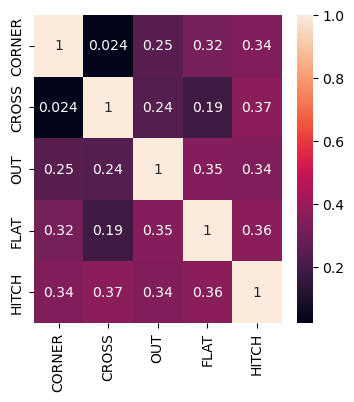

In [168]:
# Construct correlation matrix between previous 5 independent variables to determine if mullticolinearity exists
temp = qbEpaByRoute[["CORNER","CROSS","OUT","FLAT","HITCH"]]
plt.figure(figsize=(4,4))
sn.heatmap(temp.corr(),annot=True)
plt.show()

In [115]:
# Create 3rd mutiple linear regression model with 3 routes (Corner, Cross, Out) chosen after accounting for 
#  multicollinearity 
multipleLR(qbEpaByRoute[['CORNER','CROSS','OUT']])

                            OLS Regression Results                            
Dep. Variable:                   W-L%   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     9.081
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           0.000214
Time:                        17:24:45   Log-Likelihood:                 21.058
No. Observations:                  33   AIC:                            -34.12
Df Residuals:                      29   BIC:                            -28.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3695      0.034     10.803      0.0